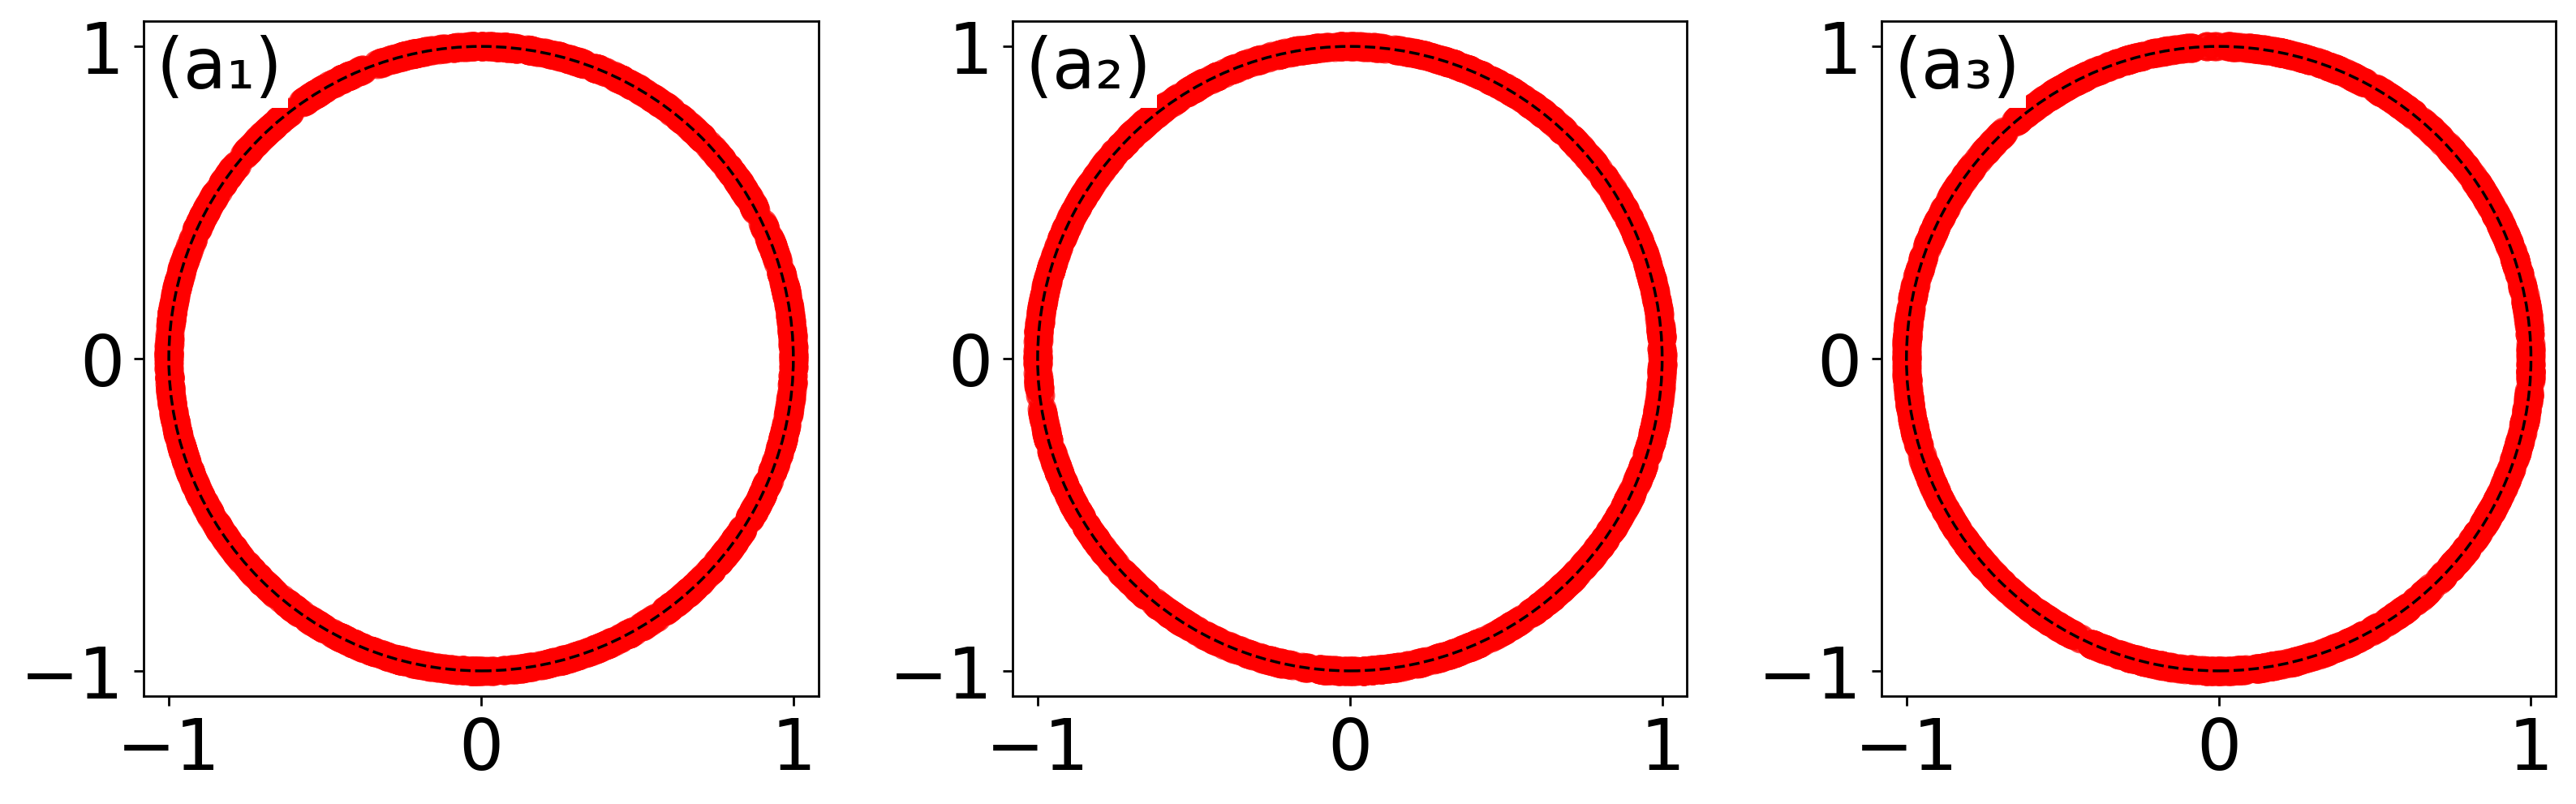

Simulation took 166.4624 seconds


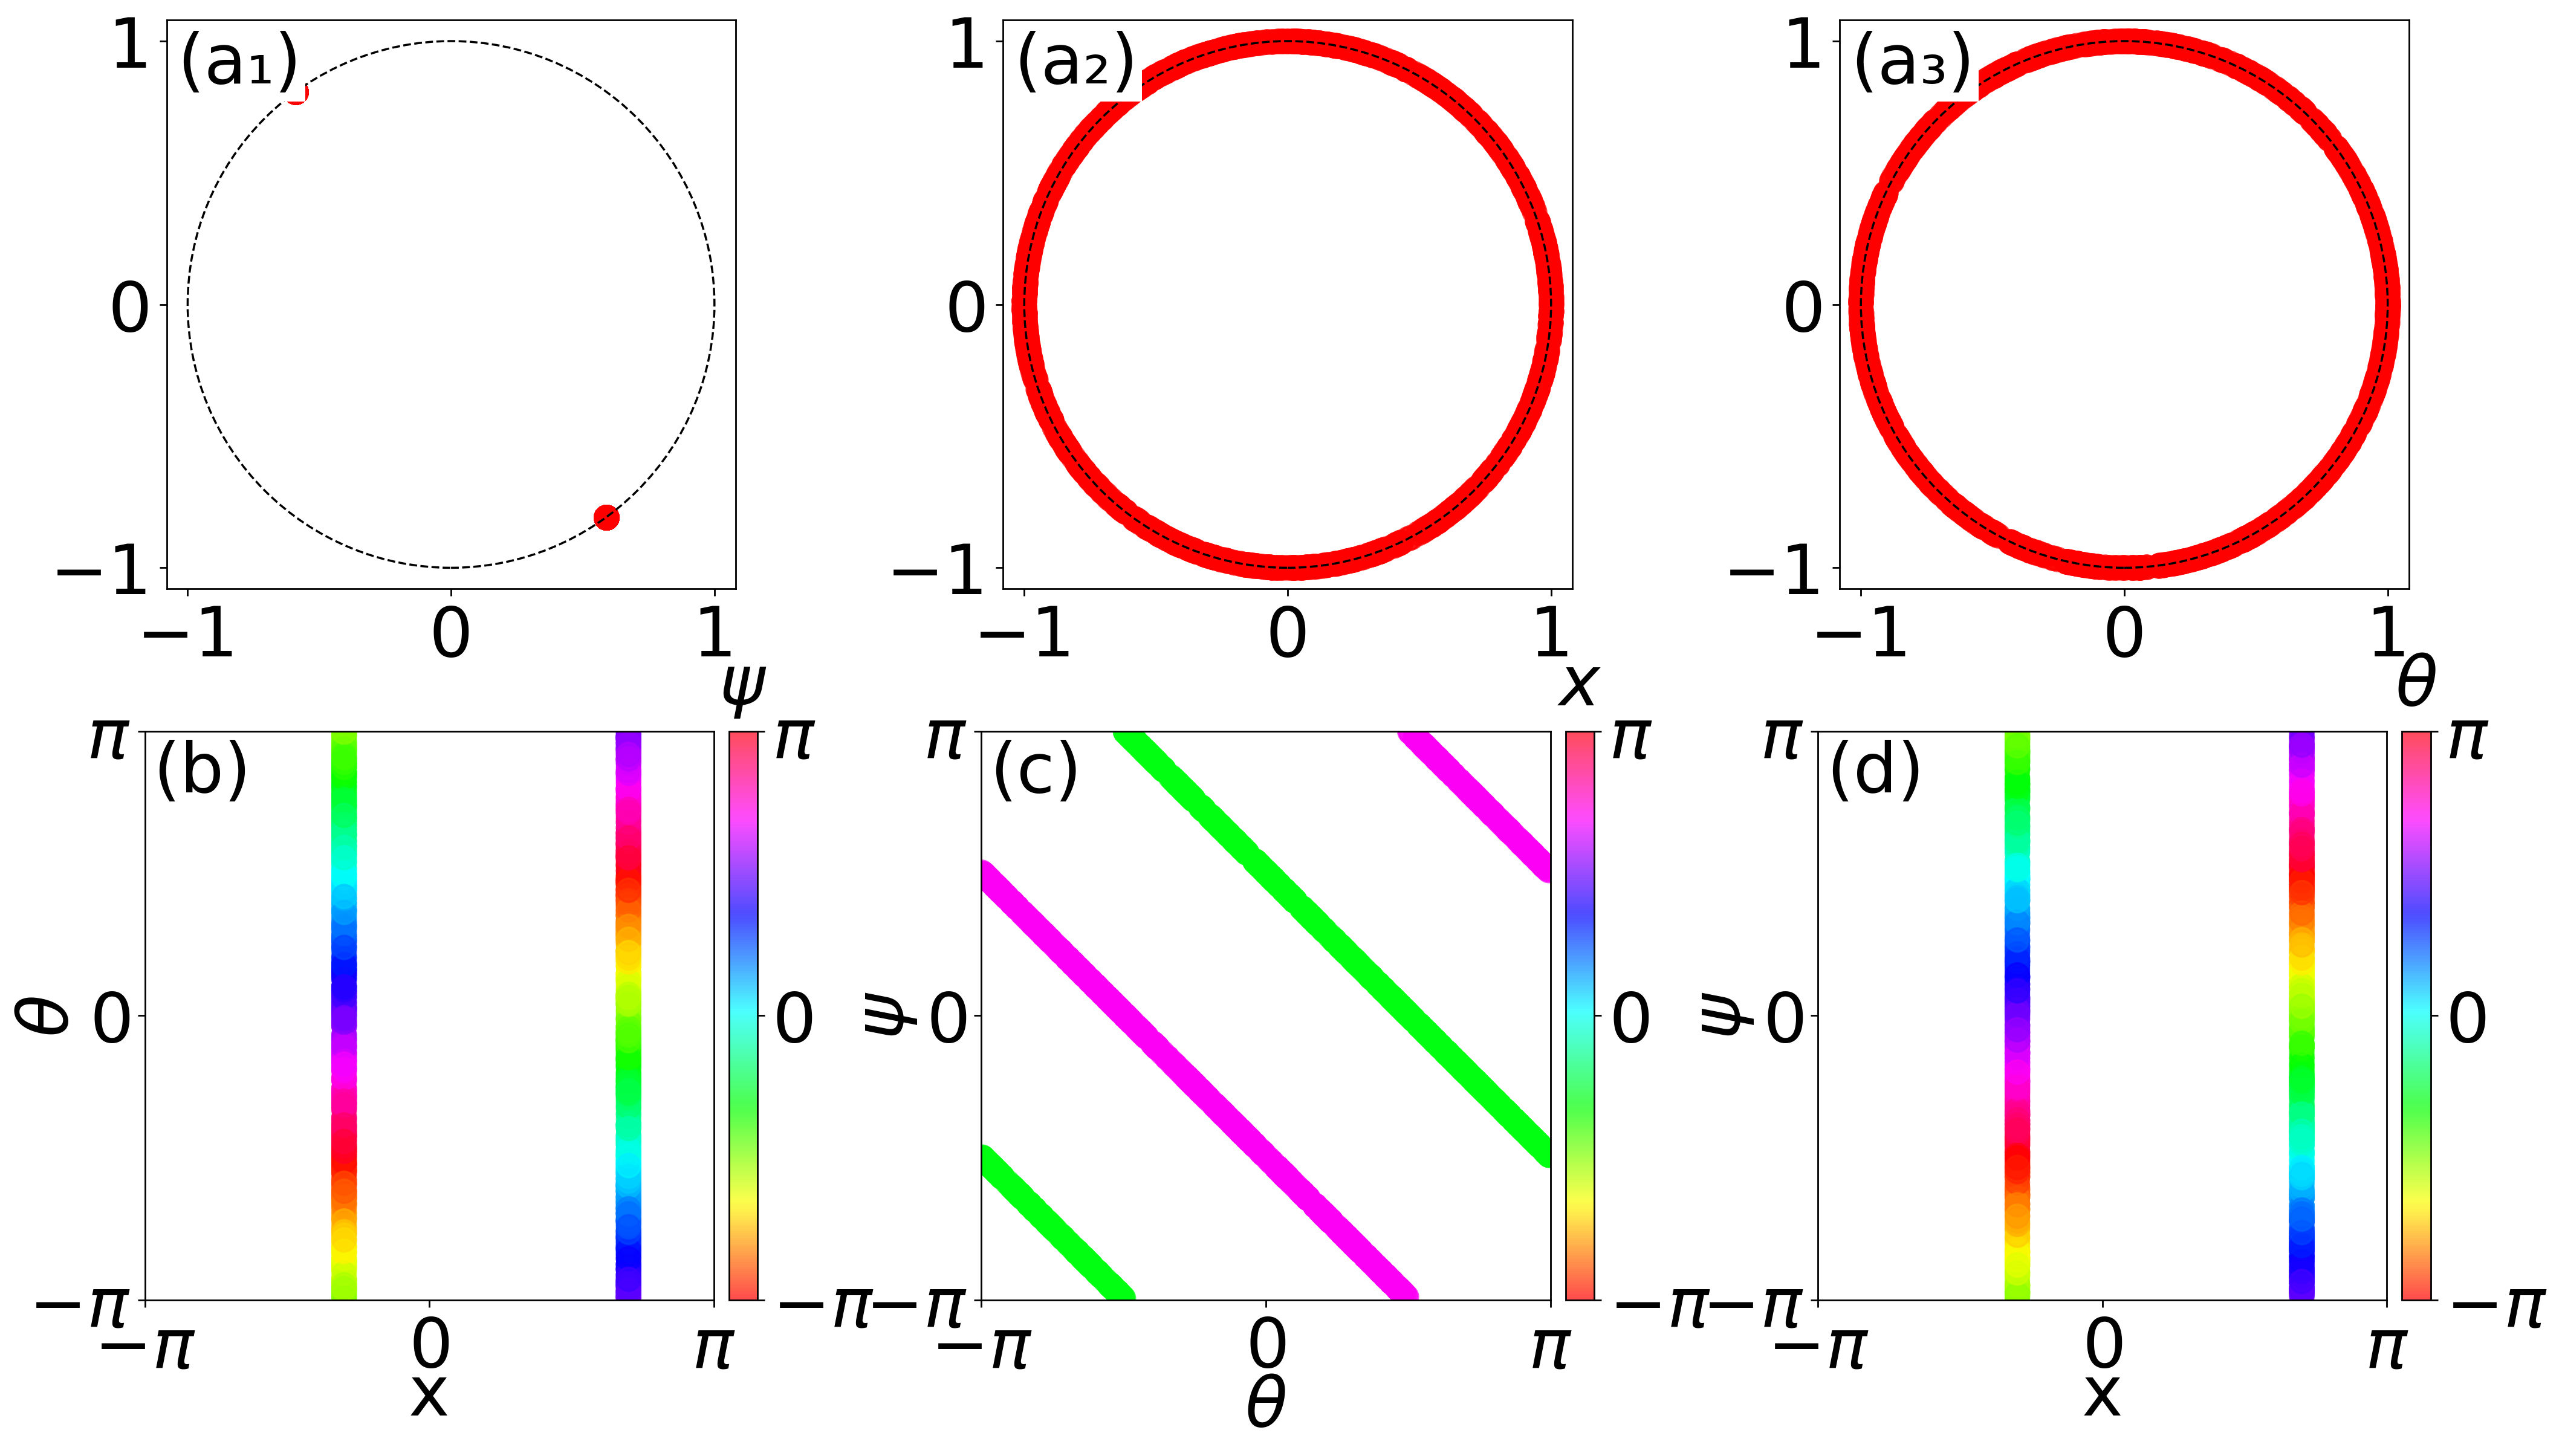

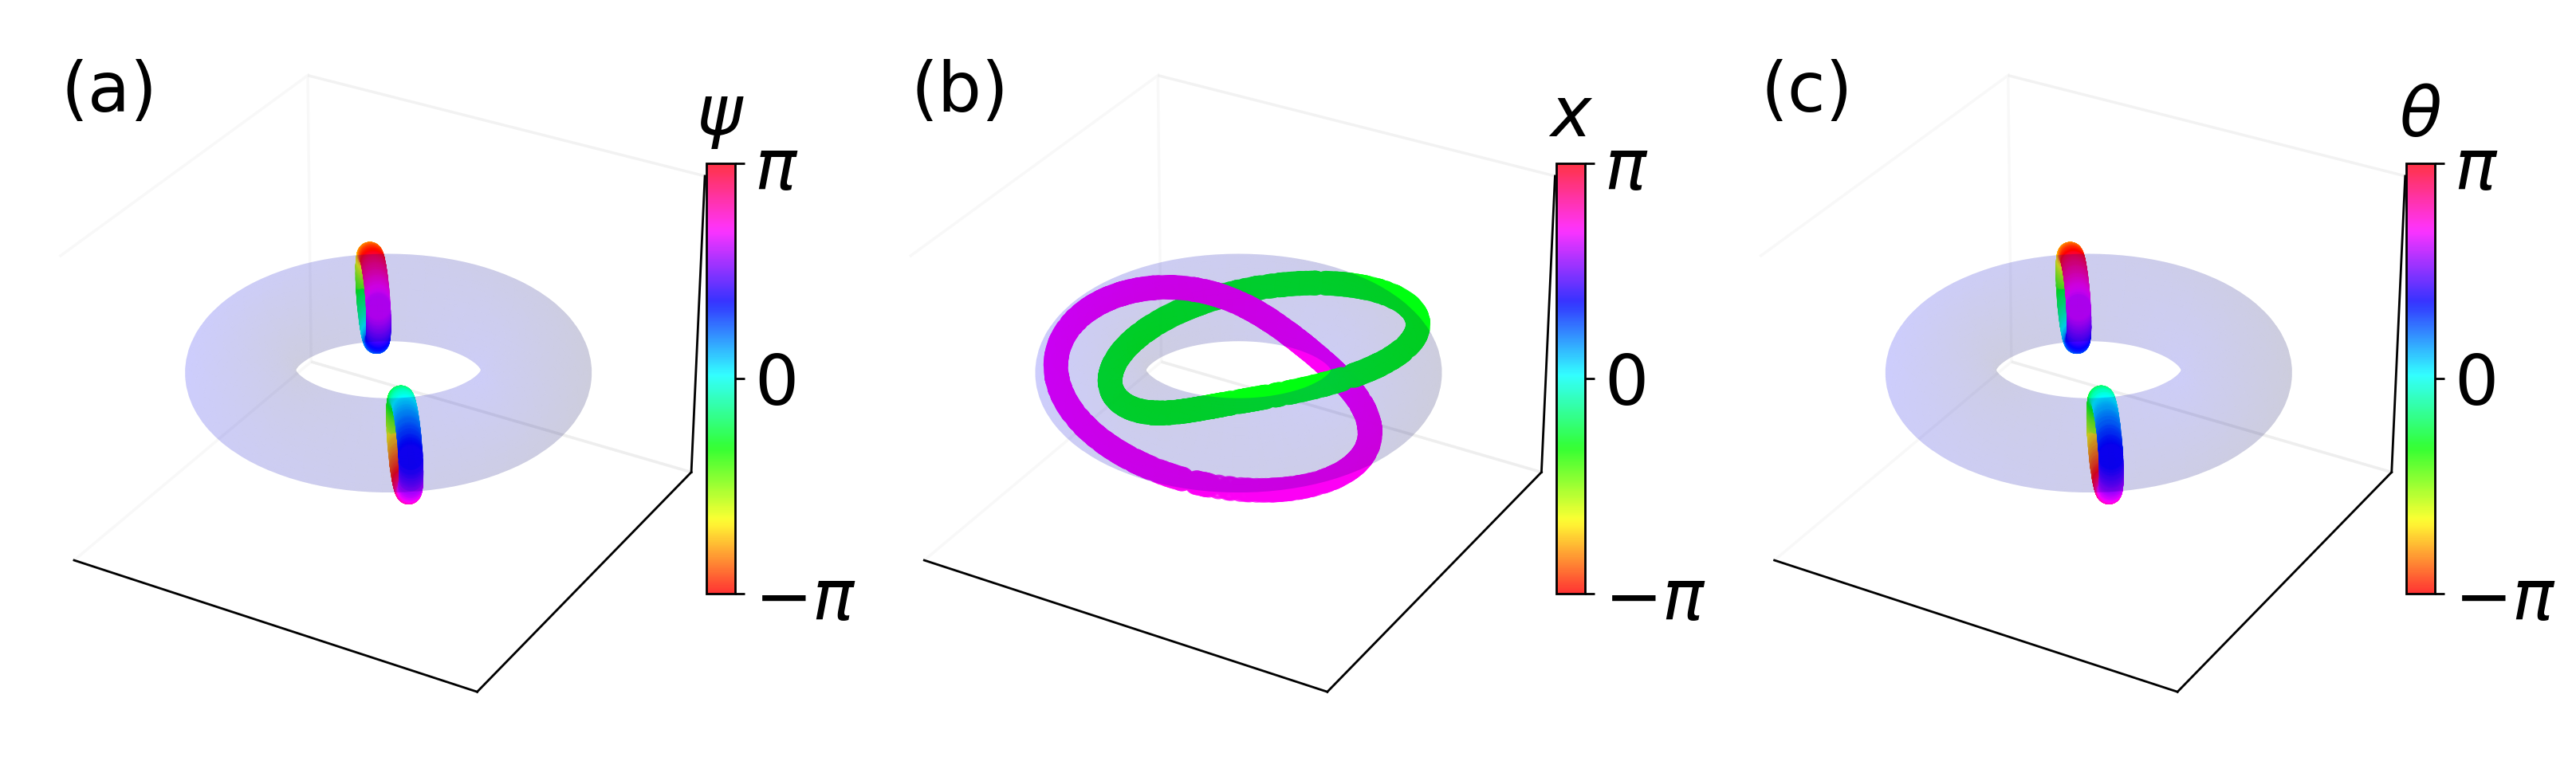

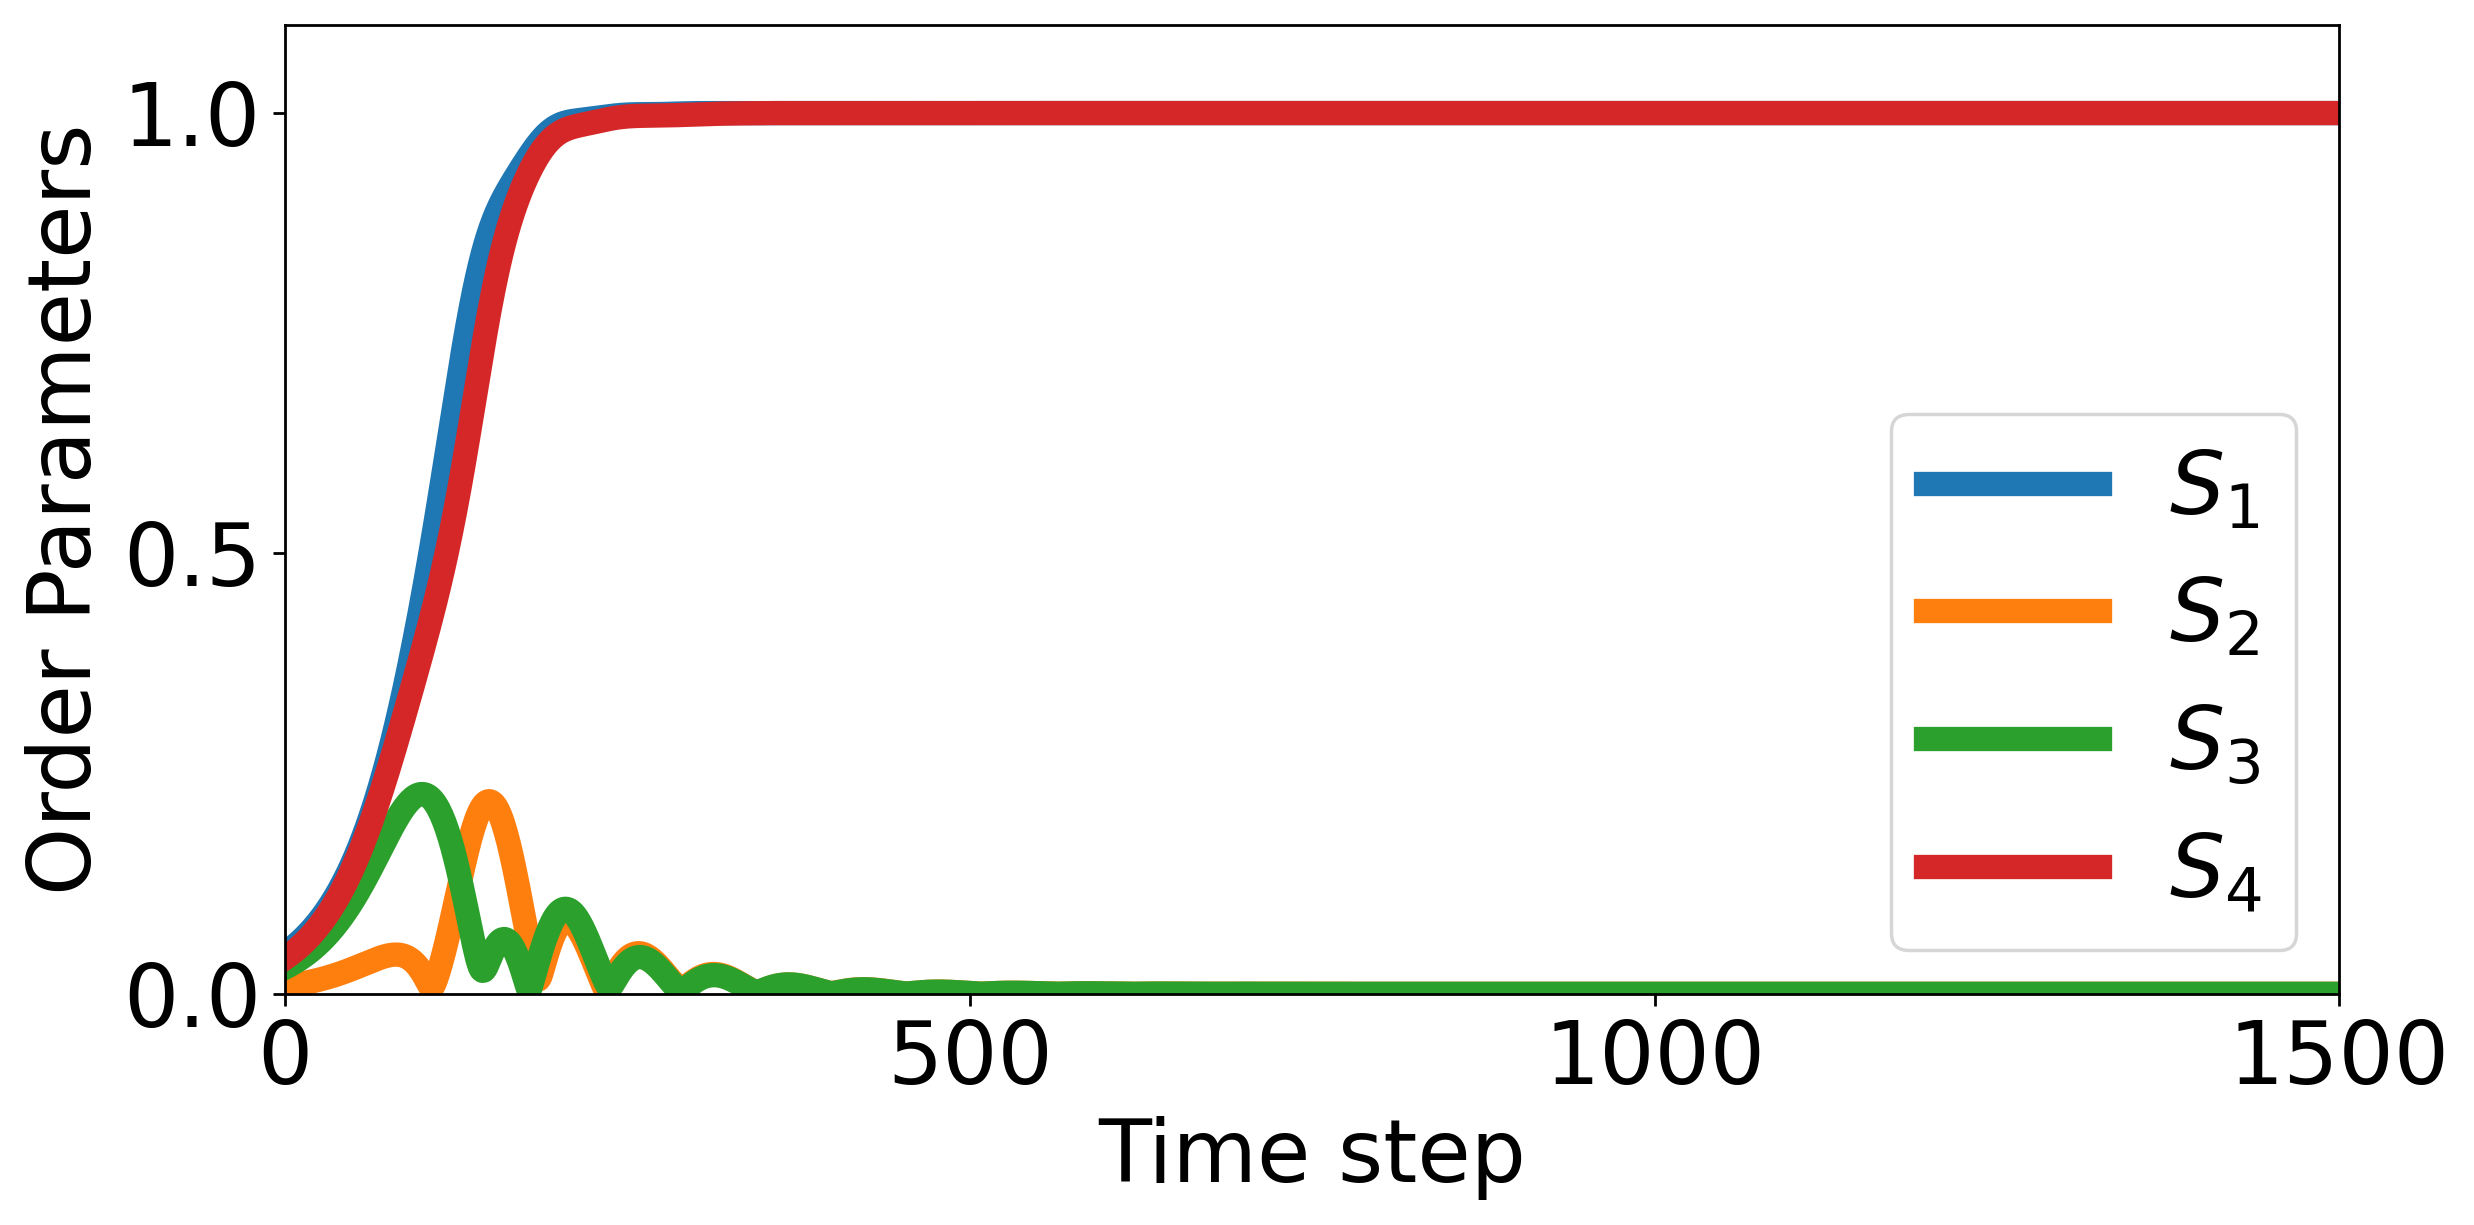

In [ ]:
#

import time
import numpy as np
from scipy.stats import cauchy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes





def set_pi_ticks(ax):
    ax.set_xticks([-np.pi, 0, np.pi])
    ax.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    ax.set_aspect('equal')


def rhs(t, z, J, K, L, n, nu, omega, mu):
    x = z[:n]
    theta = z[n:2*n]
    psi = z[2*n:3*n]
   

    xd = x[:, np.newaxis] - x
    theta_d = theta[:, np.newaxis] - theta
    psi_d = psi[:, np.newaxis] - psi

   
    x_rhs = -J * np.nan_to_num(np.sin(xd) * np.cos(theta_d) * np.cos(psi_d))
    theta_rhs = -K * np.nan_to_num(np.sin(theta_d) * np.cos(psi_d)* np.cos(xd))
    psi_rhs = -L * np.nan_to_num(np.sin(psi_d) * np.cos(xd) * np.cos(theta_d))


   
    x_next = np.nan_to_num(nu + (1/float(n)) * np.sum((1-np.eye(xd.shape[0])) * x_rhs, axis=1))
    theta_next = np.nan_to_num(omega + (1/float(n)) * np.sum((1-np.eye(xd.shape[0])) * theta_rhs, axis=1))
    psi_next = np.nan_to_num(mu + (1/float(n)) * np.sum((1-np.eye(xd.shape[0])) * psi_rhs, axis=1))
    # Normalize theta to be within [-pi, pi]
    #theta_next = np.mod(theta_next + np.pi, 2 * np.pi) - np.pi
   
    return np.concatenate((x_next, theta_next, psi_next ))

def unpack(sols, n):
    T = len(sols)  # number of timesteps
    x = np.array(np.zeros((T, n)))
    theta = np.array(np.zeros((T, n)))
    psi = np.array(np.zeros((T, n)))
    for t in range(T):
        x[t] = sols[t, 0:n]
        theta[t] = sols[t, n:2*n]
        psi[t] = sols[t, 2*n:3*n]
    return [x, theta, psi]

def find_Ws(x, theta, psi):
    numT, num_osc = x.shape
    W_1 = 1j * np.zeros(numT)
    W_2 = 1j * np.zeros(numT)
    W_3 = 1j * np.zeros(numT)
    W_4 = 1j * np.zeros(numT)
    for t in range(numT):
        W_1[t] = np.sum(np.exp(1j * (x[t, :] + theta[t, :] + psi[t, :]))) / float(num_osc)
        W_2[t] = np.sum(np.exp(1j * (x[t, :] + theta[t, :] - psi[t, :]))) / float(num_osc)
        # W_2[t] = np.sum(np.exp(1j * (x[t, :] - theta[t, :]))) / float(num_osc)
        W_3[t] = np.sum(np.exp(1j * (x[t, :] - theta[t, :] + psi[t, :]))) / float(num_osc)
        W_4[t] = np.sum(np.exp(1j * (x[t, :] - theta[t, :] - psi[t, :]))) / float(num_osc)
    return W_1, W_2, W_3, W_4


R_i = 1
r_i = 1
l_i = 1





def scatter_t(x, theta, psi, t):




    # Create figure and subplots with tighter spacing
    fig, axs = plt.subplots(2, 3, figsize=(20, 11), dpi=250,
                            gridspec_kw={'wspace': 0.25, 'hspace': 0.25})

    # Function to add dashed reference circle
    def add_circle(ax, radius):
        circle = patches.Circle((0, 0), radius, color='black', fill=False, linewidth=1, linestyle='dashed')
        ax.add_patch(circle)
        ax.set_aspect('equal')



    # Subplot (a₁)
    axs[0, 0].scatter(R_i * np.cos(np.mod(x[t, :], 2 * np.pi) - np.pi),
                    R_i * np.sin(np.mod(x[t, :], 2 * np.pi) - np.pi),
                    alpha=0.7, c='r', marker='.', s=500)
    axs[0, 0].set_xlim(-1.08, 1.08)
    axs[0, 0].set_ylim(-1.08, 1.08)
    axs[0, 0].tick_params(axis='both', which='major', labelsize=33)
    add_circle(axs[0, 0], R_i)
    axs[0, 0].text(-1.04, 1.04, '(a\u2081)', fontsize=33, ha='left', va='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

    # Subplot (a₂)
    axs[0, 1].scatter(r_i * np.cos(np.mod(theta[t, :], 2 * np.pi) - np.pi),
                    r_i * np.sin(np.mod(theta[t, :], 2 * np.pi) - np.pi),
                    alpha=0.7, c='r', marker='.', s=500)
    axs[0, 1].set_xlim(-1.08, 1.08)
    axs[0, 1].set_ylim(-1.08, 1.08)
    axs[0, 1].tick_params(axis='both', which='major', labelsize=33)
    add_circle(axs[0, 1], r_i)
    axs[0, 1].text(-1.04, 1.04, '(a\u2082)', fontsize=33, ha='left', va='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

    # Subplot (a₃)
    axs[0, 2].scatter(l_i * np.cos(np.mod(psi[t, :], 2 * np.pi) - np.pi),
                    l_i * np.sin(np.mod(psi[t, :], 2 * np.pi) - np.pi),
                    alpha=0.7, c='r', marker='.', s=500)
    axs[0, 2].set_xlim(-1.08, 1.08)
    axs[0, 2].set_ylim(-1.08, 1.08)
    axs[0, 2].tick_params(axis='both', which='major', labelsize=33)
    add_circle(axs[0, 2], l_i)
    axs[0, 2].text(-1.04, 1.04, '(a\u2083)', fontsize=33, ha='left', va='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

    # Subplot (b): x vs θ, colored by ψ
    sc1 = axs[1, 0].scatter(np.mod(x[t, :], 2 * np.pi) - np.pi,
                            np.mod(theta[t, :], 2 * np.pi) - np.pi,
                            alpha=0.7, c=(np.mod(psi[t, :], 2 * np.pi) - np.pi),
                            cmap='hsv', marker='.', s=500, vmin=-np.pi, vmax=np.pi)
    axs[1, 0].set_xlabel('x', fontsize=33)
    axs[1, 0].set_ylabel(r'$\theta$', fontsize=33)
    axs[1, 0].xaxis.set_label_coords(0.5, -0.11)
    axs[1, 0].yaxis.set_label_coords(-0.11, 0.5)
    axs[1, 0].tick_params(axis='both', which='major', labelsize=33)
    axs[1, 0].set_xlim([-np.pi, np.pi])
    axs[1, 0].set_ylim([-np.pi, np.pi])
    axs[1, 0].set_aspect('equal')
    axs[1, 0].text(-3.05, 3.05, '(b)', fontsize=33, ha='left', va='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))
    set_pi_ticks(axs[1, 0])

    divider1 = make_axes_locatable(axs[1, 0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cbar1 = fig.colorbar(sc1, cax=cax1)
    cbar1.set_ticks([-np.pi, 0, np.pi])
    cbar1.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    cbar1.ax.tick_params(labelsize=33)
    cbar1.ax.text(0.5, 1.02, r'$\psi$', fontsize=33, ha='center', va='bottom', transform=cbar1.ax.transAxes)

    # Subplot (c): θ vs ψ, colored by x
    sc2 = axs[1, 1].scatter(np.mod(theta[t, :], 2 * np.pi) - np.pi,
                            np.mod(psi[t, :], 2 * np.pi) - np.pi,
                            alpha=0.7, c=(np.mod(x[t, :], 2 * np.pi) - np.pi),
                            cmap='hsv', marker='.', s=500, vmin=-np.pi, vmax=np.pi)
    axs[1, 1].set_xlabel(r'$\theta$', fontsize=33)
    axs[1, 1].set_ylabel(r'$\psi$', fontsize=33)
    axs[1, 1].xaxis.set_label_coords(0.5, -0.13)
    axs[1, 1].yaxis.set_label_coords(-0.11, 0.5)
    axs[1, 1].tick_params(axis='both', which='major', labelsize=33)
    axs[1, 1].set_xlim([-np.pi, np.pi])
    axs[1, 1].set_ylim([-np.pi, np.pi])
    axs[1, 1].set_aspect('equal')
    axs[1, 1].text(-3.05, 3.05, '(c)', fontsize=33, ha='left', va='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))
    set_pi_ticks(axs[1, 1])

    divider2 = make_axes_locatable(axs[1, 1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cbar2 = fig.colorbar(sc2, cax=cax2)
    cbar2.set_ticks([-np.pi, 0, np.pi])
    cbar2.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    cbar2.ax.tick_params(labelsize=33)
    cbar2.ax.text(0.5, 1.02, r'$x$', fontsize=33, ha='center', va='bottom', transform=cbar2.ax.transAxes)

    # Subplot (d): x vs ψ, colored by θ
    sc3 = axs[1, 2].scatter(np.mod(x[t, :], 2 * np.pi) - np.pi,
                            np.mod(psi[t, :], 2 * np.pi) - np.pi,
                            alpha=0.7, c=(np.mod(theta[t, :], 2 * np.pi) - np.pi),
                            cmap='hsv', marker='.', s=500, vmin=-np.pi, vmax=np.pi)
    axs[1, 2].set_xlabel('x', fontsize=33)
    axs[1, 2].set_ylabel(r'$\psi$', fontsize=33)
    axs[1, 2].xaxis.set_label_coords(0.5, -0.11)
    axs[1, 2].yaxis.set_label_coords(-0.11, 0.5)
    axs[1, 2].tick_params(axis='both', which='major', labelsize=33)
    axs[1, 2].set_xlim([-np.pi, np.pi])
    axs[1, 2].set_ylim([-np.pi, np.pi])
    axs[1, 2].set_aspect('equal')
    axs[1, 2].text(-3.05, 3.05, '(d)', fontsize=33, ha='left', va='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))
    set_pi_ticks(axs[1, 2])

    divider3 = make_axes_locatable(axs[1, 2])
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cbar3 = fig.colorbar(sc3, cax=cax3)
    cbar3.set_ticks([-np.pi, 0, np.pi])
    cbar3.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    cbar3.ax.tick_params(labelsize=33)
    cbar3.ax.text(0.5, 1.02, r'$\theta$', fontsize=33, ha='center', va='bottom', transform=cbar3.ax.transAxes)

    plt.show()





    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(13, 4), dpi=250)

    def clean_3d_axes(ax):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

    u, v = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, 2*np.pi, 100))

    # --- TORUS 1 ---
    x1f1 = 4.0 * np.cos(np.mod(x[t, :], 2 * np.pi) - np.pi)
    y1f1 = 4.0 * np.sin(np.mod(x[t, :], 2 * np.pi) - np.pi)
    z1f1 = 0

    x2f1 = x1f1 + 1.5 * np.cos(np.mod(theta[t, :], 2 * np.pi) - np.pi) * np.cos(np.mod(x[t, :], 2 * np.pi) - np.pi)
    y2f1 = y1f1 + 1.5 * np.cos(np.mod(theta[t, :], 2 * np.pi) - np.pi) * np.sin(np.mod(x[t, :], 2 * np.pi) - np.pi)
    z2f1 = z1f1 + 1.5 * np.sin(np.mod(theta[t, :], 2 * np.pi) - np.pi)

    sc1 = axs[0].scatter(x2f1, y2f1, z2f1, alpha=0.8, c=(np.mod(psi[t, :], 2 * np.pi) - np.pi),
                        cmap='hsv', marker='.', s=250, vmin=-np.pi, vmax=np.pi)
    axs[0].set_xlim3d(-6, 6)
    axs[0].set_ylim3d(-6, 6)
    axs[0].set_zlim3d(-6, 6)

    X1 = (4.0 + 1.5 * np.cos(v)) * np.cos(u)
    Y1 = (4.0 + 1.5 * np.cos(v)) * np.sin(u)
    Z1 = 1.5 * np.sin(v)
    axs[0].plot_surface(X1, Y1, Z1, color='b', alpha=0.1, edgecolor='none')

    cax1 = inset_axes(axs[0], width="4%", height="60%", loc='right', borderpad=0.1)
    cbar1 = fig.colorbar(sc1, cax=cax1)
    cbar1.set_ticks([-np.pi, 0, np.pi])
    cbar1.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    cbar1.ax.tick_params(labelsize=25)
    cbar1.ax.text(0.5, 1.03, r'$\psi$', fontsize=25, ha='center', va='bottom', transform=cbar1.ax.transAxes)
    clean_3d_axes(axs[0])

    # --- TORUS 2 ---
    x1f2 = 4.0 * np.cos(np.mod(theta[t, :], 2 * np.pi) - np.pi)
    y1f2 = 4.0 * np.sin(np.mod(theta[t, :], 2 * np.pi) - np.pi)
    z1f2 = 0

    x2f2 = x1f2 + 1.5 * np.cos(np.mod(psi[t, :], 2 * np.pi) - np.pi) * np.cos(np.mod(theta[t, :], 2 * np.pi) - np.pi)
    y2f2 = y1f2 + 1.5 * np.cos(np.mod(psi[t, :], 2 * np.pi) - np.pi) * np.sin(np.mod(theta[t, :], 2 * np.pi) - np.pi)
    z2f2 = z1f2 + 1.5 * np.sin(np.mod(psi[t, :], 2 * np.pi) - np.pi)

    sc2 = axs[1].scatter(x2f2, y2f2, z2f2, alpha=0.8, c=(np.mod(x[t, :], 2 * np.pi) - np.pi),
                        cmap='hsv', marker='.', s=250, vmin=-np.pi, vmax=np.pi)
    axs[1].set_xlim3d(-6, 6)
    axs[1].set_ylim3d(-6, 6)
    axs[1].set_zlim3d(-6, 6)

    X2 = (4.0 + 1.5 * np.cos(v)) * np.cos(u)
    Y2 = (4.0 + 1.5 * np.cos(v)) * np.sin(u)
    Z2 = 1.5 * np.sin(v)
    axs[1].plot_surface(X2, Y2, Z2, color='b', alpha=0.1, edgecolor='none')

    cax2 = inset_axes(axs[1], width="4%", height="60%", loc='right', borderpad=0.1)
    cbar2 = fig.colorbar(sc2, cax=cax2)
    cbar2.set_ticks([-np.pi, 0, np.pi])
    cbar2.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    cbar2.ax.tick_params(labelsize=25)
    cbar2.ax.text(0.5, 1.03, r'$x$', fontsize=25, ha='center', va='bottom', transform=cbar2.ax.transAxes)
    clean_3d_axes(axs[1])

    # --- TORUS 3 ---
    x1f3 = 4.0 * np.cos(np.mod(x[t, :], 2 * np.pi) - np.pi)
    y1f3 = 4.0 * np.sin(np.mod(x[t, :], 2 * np.pi) - np.pi)
    z1f3 = 0

    x2f3 = x1f3 + 1.5 * np.cos(np.mod(psi[t, :], 2 * np.pi) - np.pi) * np.cos(np.mod(x[t, :], 2 * np.pi) - np.pi)
    y2f3 = y1f3 + 1.5 * np.cos(np.mod(psi[t, :], 2 * np.pi) - np.pi) * np.sin(np.mod(x[t, :], 2 * np.pi) - np.pi)
    z2f3 = z1f3 + 1.5 * np.sin(np.mod(psi[t, :], 2 * np.pi) - np.pi)

    sc3 = axs[2].scatter(x2f3, y2f3, z2f3, alpha=0.8, c=(np.mod(theta[t, :], 2 * np.pi) - np.pi),
                        cmap='hsv', marker='.', s=250, vmin=-np.pi, vmax=np.pi)
    axs[2].set_xlim3d(-6, 6)
    axs[2].set_ylim3d(-6, 6)
    axs[2].set_zlim3d(-6, 6)

    X3 = (4.0 + 1.5 * np.cos(v)) * np.cos(u)
    Y3 = (4.0 + 1.5 * np.cos(v)) * np.sin(u)
    Z3 = 1.5 * np.sin(v)
    axs[2].plot_surface(X3, Y3, Z3, color='b', alpha=0.1, edgecolor='none')

    cax3 = inset_axes(axs[2], width="4%", height="60%", loc='right', borderpad=0.1)
    cbar3 = fig.colorbar(sc3, cax=cax3)
    cbar3.set_ticks([-np.pi, 0, np.pi])
    cbar3.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    cbar3.ax.tick_params(labelsize=25)
    cbar3.ax.text(0.5, 1.03, r'$\theta$', fontsize=25, ha='center', va='bottom', transform=cbar3.ax.transAxes)
    clean_3d_axes(axs[2])

    # Add subplot labels
    axs[0].text(-6.1, -6.1, 11.8, "(a)", fontsize=25)
    axs[1].text(-6.1, -6.1, 11.8, "(b)", fontsize=25)
    axs[2].text(-6.1, -6.1, 11.8, "(c)", fontsize=25)

    fig.subplots_adjust(left=0.03, right=0.99, top=0.95, bottom=0.05, wspace=0.08)




 


# Simulation parameters
dt, T, n  = 0.1, 300, 1000
# dt, T, n  = 0.1, 200, 200



# np.random.seed(0)
np.random.seed()

x0 = np.random.uniform(-np.pi, np.pi, n)
# x0 = np.full(n, 0.1)  + 5e-2 * np.random.randn(n)    # Initial value of x for all oscillators
# x0 = np.full(n, 0.3)

theta0 = np.random.uniform(-np.pi, np.pi, n)
# theta0 = np.full(n, 0.3) + 8e-2 * np.random.randn(n)   # Initial value of theta
# theta0 = np.full(n, 0.5)

psi0 = np.random.uniform(-np.pi, np.pi, n)
# psi0 = np.full(n, 0.5) + 1e-1 * np.random.randn(n)    # Initial value of psi (if used in your model)
# psi0 = np.full(n, 0.5)




fig, axs = plt.subplots(1, 3, figsize=(13, 4), dpi=250)
ax1, ax2, ax3 = axs

def add_circle(ax, radius):
    circle = patches.Circle((0, 0), radius, color='black', fill=False, linewidth=1, linestyle='dashed')
    ax.add_patch(circle)
    ax.set_aspect('equal')

# Subplot (a)
ax1.scatter(R_i * np.cos(np.mod(x0, 2 * np.pi) - np.pi),
            R_i * np.sin(np.mod(x0, 2 * np.pi) - np.pi),
            alpha=0.7, c='r', marker='.', s=350)
ax1.set_xlim(-1.08, 1.08)
ax1.set_ylim(-1.08, 1.08)
ax1.tick_params(axis='both', which='major', labelsize=25)
add_circle(ax1, R_i)
ax1.text(-1.04, 1.04, '(a\u2081)', fontsize=25, ha='left', va='top',
         bbox=dict(facecolor='white', edgecolor='none', pad=2))  # ← INSIDE top-left

# Subplot (b)
ax2.scatter(r_i * np.cos(np.mod(theta0, 2 * np.pi) - np.pi),
            r_i * np.sin(np.mod(theta0, 2 * np.pi) - np.pi),
            alpha=0.7, c='r', marker='.', s=350)
ax2.set_xlim(-1.08, 1.08)
ax2.set_ylim(-1.08, 1.08)
ax2.tick_params(axis='both', which='major', labelsize=25)
add_circle(ax2, r_i)
ax2.text(-1.04, 1.04, '(a\u2082)', fontsize=25, ha='left', va='top',
         bbox=dict(facecolor='white', edgecolor='none', pad=2))

# Subplot (c)
ax3.scatter(l_i * np.cos(np.mod(psi0, 2 * np.pi) - np.pi),
            l_i * np.sin(np.mod(psi0, 2 * np.pi) - np.pi),
            alpha=0.7, c='r', marker='.', s=350)
ax3.set_xlim(-1.08, 1.08)
ax3.set_ylim(-1.08, 1.08)
ax3.tick_params(axis='both', which='major', labelsize=25)
add_circle(ax3, l_i)
ax3.text(-1.04, 1.04, '(a\u2083)', fontsize=25, ha='left', va='top',
         bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.tight_layout()
plt.show()




t = np.arange(0, T, dt)  # Generate time array

# # Physical parameters

nu, omega, mu = 0, 0, 0
# nu, omega, mu = 1.0, 2.0, 3.0

# # # sync
# J = 1.0
# K = 1.0
# L = 1.0

# CC-I
J = 1.0
K = 1.5
L = -0.5

# # CC-II
# J = 1.0
# K = 0.25
# L = -0.75

# # CC-III
# J = 1.0
# K = -0.75
# L = 0.25

# # ThPW
# J = 1.0
# K = -1.25
# L = 0.8

# # Async
# J = 1.0
# K = 0.5
# L = -2.0

# # HA & HA_ptd
# J = -1.0
# K = -1.0
# L = -1.0




z0 = np.concatenate([x0, theta0, psi0])  # Initial conditions flattened

# Do simulation
tic = time.perf_counter()
sol = solve_ivp(rhs, [0, T], z0, args=(J, K, L, n, nu, omega, mu), t_eval=t, method='RK45', rtol=1e-6, atol=1e-9)
toc = time.perf_counter()
print(f"Simulation took {toc - tic:0.4f} seconds")

# Unpack the solution
sols = sol.y.T  # Transpose to match odeint output
x, theta, psi = unpack(sols, n)

# Plot
scatter_t(x, theta, psi, -1)




plt.figure(figsize=(10, 5), dpi=250)

# Compute order parameters
W_1, W_2, W_3, W_4 = find_Ws(x, theta, psi)

# Truncate to first 2000 time steps
# T = 1000  #sync, CC-1
T = 1500   # CC-II, CC-III, ThPW
# T = 1000   # Async, HA, [ consider Y-axis scale as well]

plt.plot(np.abs(W_1[:T]), linewidth=7)
plt.plot(np.abs(W_2[:T]), linewidth=7)
plt.plot(np.abs(W_3[:T]), linewidth=7)
plt.plot(np.abs(W_4[:T]), linewidth=7)

# Axis labels and legend
plt.xlabel('Time step', fontsize=25)
plt.ylabel('Order Parameters', fontsize=25)
plt.legend([r'$S_1$', r'$S_2$', r'$S_3$', r'$S_4$'], fontsize=25)

# Axis limits
plt.xlim(0, T)
plt.ylim(0, 1.1)
# plt.ylim(0, 0.4)
# plt.xticks([0, 500, 1000])
plt.xticks([0, 500, 1000, 1500])
plt.yticks([0, 0.5, 1.0])
# plt.yticks([0, 0.2, 0.4])
plt.tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()
plt.show()